# DM3: Recommender Systems

## Data preprocessing

First of all, we read the datasets and merge them, joining on the movieId attribute.

In [1]:
import pandas as pd

movies = pd.read_csv("../datasets/movies.csv")
ratings = pd.read_csv("../datasets/ratings_train.csv")
print(movies.head())
print(ratings.head())

movies_ratings_dataset = pd.merge(ratings, movies, on='movieId')
movies_ratings_dataset

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
97796,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
97797,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
97798,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
97799,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


We can check for missing values by printing this below. It seems like there are no missing values and thus no handling is needed.

In [2]:
print(movies_ratings_dataset.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


For future use, we will convert the genres from a string, separating with | to a list of genres:

In [3]:
movies_ratings_dataset['genres'] = movies_ratings_dataset['genres'].str.split('|')
print(movies_ratings_dataset['genres'])

0        [Adventure, Animation, Children, Comedy, Fantasy]
1        [Adventure, Animation, Children, Comedy, Fantasy]
2        [Adventure, Animation, Children, Comedy, Fantasy]
3        [Adventure, Animation, Children, Comedy, Fantasy]
4        [Adventure, Animation, Children, Comedy, Fantasy]
                               ...                        
97796                                   [Action, Thriller]
97797                               [Action, Crime, Drama]
97798                            [Action, Drama, Thriller]
97799                                   [Horror, Thriller]
97800                                             [Horror]
Name: genres, Length: 97801, dtype: object


I noticed that the user ids go up to 610, but there are only 600 users, I found which users are missing.

In [4]:
print(len(movies_ratings_dataset['userId'].unique()))
missing_user_ids = sorted(set(range(1, 610)) - set(movies_ratings_dataset['userId'].unique().tolist()))
print(missing_user_ids)

600
[31, 40, 219, 228, 245, 369, 381, 450, 480, 483]


 We convert the rating's Unix epoch format timestamps to human-readable datetime, as well as parsing the release date of movies that are given in the title, and adding it in a new column.

In [5]:
# Convert timestamp to readable format
movies_ratings_dataset['timestamp'] = pd.to_datetime(movies_ratings_dataset['timestamp'], unit='s')
print(movies_ratings_dataset['timestamp'])

# Extract Year from title and put in new column
movies_ratings_dataset['releaseYear'] = movies_ratings_dataset['title'].str.extract(r'\((\d{4})\)').astype(float)
print(movies_ratings_dataset[movies_ratings_dataset['releaseYear'].isna()])


# Give missing years the year of first rating given
movies_ratings_dataset['ratingYear'] = movies_ratings_dataset['timestamp'].dt.year
first_rating_year = movies_ratings_dataset.groupby('movieId')['ratingYear'].min()

movies_ratings_dataset['releaseYear'] = movies_ratings_dataset.apply(
    lambda row: first_rating_year[row['movieId']] if pd.isna(row['releaseYear']) else row['releaseYear'],
    axis=1
)

print("Remaining NaN values: ",len(movies_ratings_dataset[movies_ratings_dataset['releaseYear'].isna()]))


0       2000-07-30 18:45:03
1       1996-11-08 06:36:02
2       2005-01-25 06:52:26
3       2017-11-13 12:59:30
4       2011-05-18 05:28:03
                ...        
97796   2016-11-19 08:55:49
97797   2016-11-19 08:43:18
97798   2017-05-03 20:53:14
97799   2017-05-03 21:59:49
97800   2017-05-03 22:22:35
Name: timestamp, Length: 97801, dtype: datetime64[ns]
       userId  movieId  rating           timestamp  \
78912      62   176601     5.0 2018-05-08 16:00:52   
85876     105   147250     5.0 2018-05-13 10:29:14   
85898     105   171749     5.0 2018-05-13 10:29:25   
86699     111   171631     1.0 2018-01-31 23:21:49   
86702     111   171891     3.5 2018-01-31 23:09:59   
90574     209   140956     3.5 2018-04-23 22:23:59   
90575     305   140956     4.5 2018-07-31 13:26:17   
90576     380   140956     3.0 2018-08-13 16:02:38   
90577     514   140956     3.0 2018-08-11 00:08:39   
90593     210    40697     4.0 2018-05-25 16:36:31   
90594     528    40697     0.5 2014-02-07 01

A little insight for the Star wars lovers (the prequels deserve more love..)

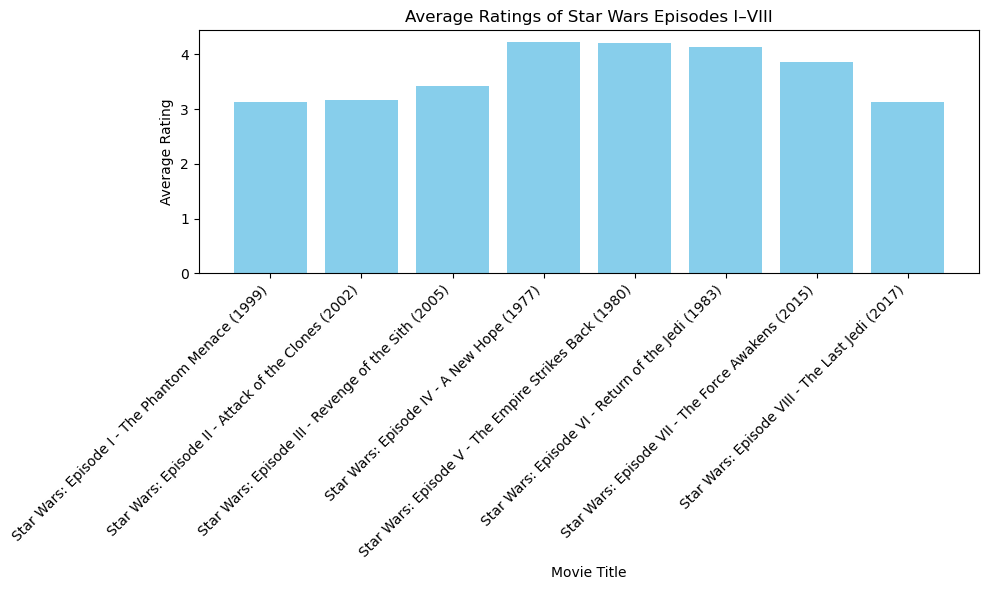

In [6]:
import matplotlib.pyplot as plt

star_wars = movies_ratings_dataset[movies_ratings_dataset['title'].str.contains(r'Star Wars: Episode [I|V|X]*', regex=True, case=False)]
avg_ratings = star_wars.groupby('title')['rating'].mean().reset_index()

episode_order = [
    "Star Wars: Episode I - The Phantom Menace (1999)",
    "Star Wars: Episode II - Attack of the Clones (2002)",
    "Star Wars: Episode III - Revenge of the Sith (2005)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Star Wars: Episode V - The Empire Strikes Back (1980)",
    "Star Wars: Episode VI - Return of the Jedi (1983)",
    "Star Wars: Episode VII - The Force Awakens (2015)",
    "Star Wars: Episode VIII - The Last Jedi (2017)"
]

avg_ratings['episode'] = avg_ratings['title'].apply(lambda t: episode_order.index(t) if t in episode_order else -1)
avg_ratings = avg_ratings[avg_ratings['episode'] >= 0].sort_values('episode')

plt.figure(figsize=(10, 6))
plt.bar(avg_ratings['title'], avg_ratings['rating'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Average Ratings of Star Wars Episodes I–VIII')
plt.ylabel('Average Rating')
plt.xlabel('Movie Title')
plt.tight_layout()
plt.show()


# TASK 1

We can split the data randomly like:

In [7]:
# 1. Random split
def split_random(df):
    train_df = df.sample(frac=0.8, random_state=42)
    test_df = df.drop(train_df.index)
    return train_df, test_df

Or split based on the time of recomendations.

In [8]:
# 2. Time-based split
def split_timebased(df):
    # Anything after certain point is test data
    sorted_on_timestamp = df.sort_values('timestamp')
    split_index = int(0.8 * len(sorted_on_timestamp))
    train_df = sorted_on_timestamp.iloc[:split_index]
    test_df = sorted_on_timestamp.iloc[split_index:]
    return train_df, test_df

Another way could be to split the data for each user independently.

In [9]:
# 3. User-wise split
def split_userwise(df):
    train_rows = []
    test_rows = []

    # Split 80/20 for each user independently
    for user_id, group in df.groupby("userId"):
        group = group.sort_values('timestamp')
        n = len(group)
        split_idx = int(0.8 * n)

        train_rows.append(group.iloc[:split_idx])
        test_rows.append(group.iloc[split_idx:])

    # Combine all splitted ratings
    train_df = pd.concat(train_rows).reset_index(drop=True)
    test_df = pd.concat(test_rows).reset_index(drop=True)
    return train_df, test_df

Now let's prepare the train- and testset.

In [10]:
from surprise import Dataset, Reader

def prepare_train_test(train_df, test_df):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()

    testset = []
    all_movie_ids = set(movies_ratings_dataset['movieId'].unique())
    user_rated = train_df.groupby('userId')['movieId'].apply(set).to_dict()
    user_unrated_map = defaultdict(list)

    # Only include movies that user has not rated yet
    for user_id in test_df['userId'].unique():
        rated = user_rated.get(user_id, set())
        unrated = all_movie_ids - rated
        for movie_id in unrated:
            testset.append((user_id, movie_id, 0)) # 0 is placeholder for rating
            user_unrated_map[user_id].append(movie_id)

    return trainset, testset

It is important to check how many users of the test are also present in the train data. Only having unseen users in the testdataset will result in no thought through recommendations, while no unseen users are not accurate to the real world.


In [11]:
# Check how many users in test are also in train dataset
def check_cold_users(trainset, testset):
    train_users = set([trainset.to_raw_uid(u) for u in trainset.all_users()])
    test_users = set([uid for (uid, _, _) in testset])
    common_users = train_users & test_users

    print(f"Total users in training set: {len(train_users)}")
    print(f"Total users in test set: {len(test_users)}")
    print(f"Users in both train and test: {len(common_users)}")
    print(test_users - common_users)
    print(f"Percentage of test users also in training: {100 * len(common_users) / len(test_users):.2f}%")

## Algorithms

The first recommender model we will try is KNNBasic.

In [12]:
from surprise import KNNBasic

# KNN
def KNN_predict(trainset, testset, sim_options):
    knn_model = KNNBasic(sim_options=sim_options)
    knn_model.fit(trainset)
    knn_preds = knn_model.test(testset)
    return knn_preds

SVD is the next model we will compare.

In [13]:
from surprise import SVD

# SVD
def SVD_predict(trainset, testset, n_factors=50, n_epochs=30, lr_all=0.007, reg_all=0.05):
    svd_model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
    svd_model.fit(trainset)
    svd_preds = svd_model.test(testset)
    return svd_preds

We calculate precision and recall to check the performance of the model.

In [14]:
from collections import defaultdict

def get_top_k(predictions, k=10):
    top_k = defaultdict(list)
    for pred in predictions:
        top_k[pred.uid].append((pred.iid, pred.est))
    # Sort and take top-k
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = [iid for iid, _ in user_ratings[:k]]
    return top_k

def evaluate_top_k(k, top_k, test_df, relevance_threshold=3.5):
    # Build actual relevant items per user
    actual = defaultdict(set)
    for _, row in test_df.iterrows():
        if row['rating'] >= relevance_threshold:  # Assuming relevance threshold
            actual[row["userId"]].add(row["movieId"])

    precisions = []
    recalls = []

    for uid, predicted_items in top_k.items():
        # Skip if user has no relevant items in ground truth
        if uid not in actual or not actual[uid]:
            continue

        pred_set = set(predicted_items)
        true_set = actual[uid]
        intersection = pred_set & true_set

        # Precision = proportion of recommended items that are relevant
        precision = len(intersection) / len(pred_set)

        # Recall = proportion of relevant items that were recommended
        recall = len(intersection) / len(true_set)


        precisions.append(precision)
        recalls.append(recall)

    mean_precision = sum(precisions) / len(precisions) if precisions else 0
    mean_recall = sum(recalls) / len(recalls) if recalls else 0

    f1_scores = [2 * (p * r) / (p + r) for p, r in zip(precisions, recalls) if (p + r) > 0]
    mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    return {
        "Precision@"+str(k): mean_precision,
        "Recall@"+str(k): mean_recall,
        "F1@"+str(k): mean_f1
    }

Now lets test different setups and put them in a table.

In [18]:
def run_all_evaluations(df):
    all_results = []

    split_methods = {
        "Random": split_random,
        "TimeBased": split_timebased,
        "UserWise": split_userwise,
    }

    knn_sim_options_list = [
        {"name": "cosine", "user_based": True},
        {"name": "cosine", "user_based": False},
        {"name": "pearson", "user_based": True},
        {"name": "msd", "user_based": True}
    ]

    svd_params_grid = [
        {"n_factors": 50, "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02},
        {"n_factors": 100, "n_epochs": 30, "lr_all": 0.007, "reg_all": 0.05},
        {"n_factors": 30, "n_epochs": 15, "lr_all": 0.01, "reg_all": 0.01}
    ]

    for split_name, split_func in split_methods.items():
        print(f"\n=== Evaluating Split: {split_name} ===")

        # Split correctly
        train_df, test_df = split_func(df)
        trainset, testset = prepare_train_test(train_df, test_df)

        # KNN
        for sim_opts in knn_sim_options_list:
            label = f"KNN-{sim_opts['name']}-{'user' if sim_opts['user_based'] else 'item'}"
            preds = KNN_predict(trainset, testset, sim_opts)
            metrics = {}
            metrics["Model"] = label
            metrics["Split"] = split_name
            # Test for k 1, 3 and 10
            for k in [1,3,10]:
                top_k = get_top_k(preds, k)
                metrics.update(evaluate_top_k(k, top_k, test_df))
                all_results.append(metrics)
            print(metrics)
            all_results.append(metrics)

        # SVD
        for svd_params in svd_params_grid:
            label = f"SVD-f{svd_params['n_factors']}-lr{svd_params['lr_all']}"
            preds = SVD_predict(trainset, testset, **svd_params)
            metrics = {}
            metrics["Model"] = label
            metrics["Split"] = split_name
            # Test for k 1, 3 and 10
            for k in [1,3,10]:
                top_k = get_top_k(preds, k)
                metrics.update(evaluate_top_k(k, top_k, test_df))
            print(metrics)
            all_results.append(metrics)

    # Build DataFrame
    df_results = pd.DataFrame(all_results)
    df_results.set_index(["Split", "Model"], inplace=True)
    df_results.to_csv("results.csv")
    return df_results


df_results = run_all_evaluations(movies_ratings_dataset)
print(df_results)



=== Evaluating Split: Random ===
Computing the cosine similarity matrix...
Done computing similarity matrix.
{'Model': 'KNN-cosine-user', 'Split': 'Random', 'Precision@1': 0.0017035775127768314, 'Recall@1': 0.0003407155025553663, 'F1@1': 0.33333333333333337, 'Precision@3': 0.0005678591709256105, 'Recall@3': 0.0003407155025553663, 'F1@3': 0.25, 'Precision@10': 0.00017035775127768315, 'Recall@10': 0.0003407155025553663, 'F1@10': 0.13333333333333333}
Computing the cosine similarity matrix...
Done computing similarity matrix.
{'Model': 'KNN-cosine-item', 'Split': 'Random', 'Precision@1': 0.0, 'Recall@1': 0.0, 'F1@1': 0, 'Precision@3': 0.0, 'Recall@3': 0.0, 'F1@3': 0, 'Precision@10': 0.00017035775127768315, 'Recall@10': 1.3738528328845414e-05, 'F1@10': 0.014925373134328358}
Computing the pearson similarity matrix...
Done computing similarity matrix.
{'Model': 'KNN-pearson-user', 'Split': 'Random', 'Precision@1': 0.0034071550255536627, 'Recall@1': 0.0006246450880181716, 'F1@1': 0.3095238095

In [19]:
# Drop F1 to fit table in report
df_results = df_results.drop(columns=["F1@1", "F1@3", "F1@10"])
print(df_results.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
         &                &  Precision@1 &  Recall@1 &  Precision@3 &  Recall@3 &  Precision@10 &  Recall@10 \\
Split & Model &              &           &              &           &               &            \\
\midrule
Random & KNN-cosine-user &     0.001704 &  0.000341 &     0.000568 &  0.000341 &      0.000170 &   0.000341 \\
         & KNN-cosine-user &     0.001704 &  0.000341 &     0.000568 &  0.000341 &      0.000170 &   0.000341 \\
         & KNN-cosine-user &     0.001704 &  0.000341 &     0.000568 &  0.000341 &      0.000170 &   0.000341 \\
         & KNN-cosine-user &     0.001704 &  0.000341 &     0.000568 &  0.000341 &      0.000170 &   0.000341 \\
         & KNN-cosine-item &     0.000000 &  0.000000 &     0.000000 &  0.000000 &      0.000170 &   0.000014 \\
         & KNN-cosine-item &     0.000000 &  0.000000 &     0.000000 &  0.000000 &      0.000170 &   0.000014 \\
         & KNN-cosine-item &     0.000000 &  0.000000 &     0.000000

# TASK 2

Let's now use the best model to fill in the ratings_test.csv.

In [17]:
# Train on full dataset now
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(movies_ratings_dataset[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()


# Prepare testset
test_df = pd.read_csv("../datasets/ratings_test.csv")

testset = []
all_movie_ids = set(movies_ratings_dataset['movieId'].unique())
user_rated = movies_ratings_dataset.groupby('userId')['movieId'].apply(set).to_dict()
user_unrated_map = defaultdict(list)

for user_id in test_df['userId'].unique():
    rated = user_rated.get(user_id, set())
    unrated = all_movie_ids - rated
    for movie_id in unrated:
        testset.append((user_id, movie_id, 0))
        user_unrated_map[user_id].append(movie_id)

print(check_cold_users(trainset, testset))

# get predictions of best model
svd_preds = SVD_predict(trainset, testset, **{"n_factors": 50, "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02})

# put 10 best predictions in csv
top_10_preds = get_top_k(svd_preds, k=10)
top_10_df = pd.DataFrame.from_dict(top_10_preds, orient='index')
top_10_df.columns = [f'recommendation{i+1}' for i in range(top_10_df.shape[1])]

top_10_df.reset_index(inplace=True)
top_10_df.rename(columns={'index': 'userId'}, inplace=True)

top_10_df.to_csv("../datasets/ratings_test.csv", index=False)
top_10_df

Total users in training set: 600
Total users in test set: 100
Users in both train and test: 90
{480, 450, 483, 228, 40, 369, 245, 219, 381, 31}
Percentage of test users also in training: 90.00%
None


,userId,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6,recommendation7,recommendation8,recommendation9,recommendation10
0,3,8874,1148,898,6711,246,55247,910,1207,969,1248
1,7,1136,1225,8132,912,2571,1089,1204,1245,1228,6711
2,11,858,2959,1217,1223,79132,1276,2324,898,750,1136
3,25,50,246,296,318,356,541,741,750,858,922
4,30,527,750,858,899,904,912,1104,1178,1204,1208
...,...,...,...,...,...,...,...,...,...,...,...
95,587,58559,2398,68954,318,78499,922,4011,364,110,2028
96,592,1198,858,2571,475,527,2959,1213,1148,1204,7361
97,599,527,475,1193,1250,1262,246,1276,1234,903,2067
98,606,922,1148,1197,1104,5690,1252,1233,1283,1276,608
